In [1]:
%matplotlib inline
import pandas as pd
import urllib as ur
import json
import datetime
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

## Coletando a duração de cada viagem.

In [2]:
# Lendo csv de intervalos de ociosidade e ocupação
dfOccupied = pd.read_csv('../travels_id_tratado.csv')
dfParked = pd.read_csv('../parked_id.csv')

In [3]:
car_ids = list(dfOccupied.Id.unique())

print(datetime.datetime.now())

# Removing uncommon ids
# Ex: 4c5865a3-4b03-40f6-a3a8-d4e94aae3b17
car_ids = [id for id in car_ids if id.find('-') == -1]# Coletando os ids dos veículos

print(datetime.datetime.now())

2018-11-12 18:40:17.825523
2018-11-12 18:40:17.826689


In [4]:
def Hour_Diff(h1,h2):
    """
    Faz a diferença entre duas horas dadas e retorna em minutos
    
    Parameters
    ----------
    h1, h2 : unix timestamp
        Hora inicio e fim para ser feito o cálculo da diferença
        
    Returns
    ---------
    diff : float
        Diferença entre as duas horas dadas em minutos
        
    """
    
    h1Aux = datetime.datetime.fromtimestamp(h1)
    h2Aux = datetime.datetime.fromtimestamp(h2)
    diff = abs((h1Aux - h2Aux)).total_seconds()/60
    
    return diff

In [5]:
def str_to_datetime(df_time):
    """ 
    Reformatando de string para datetime.
    
    Parameters
    ----------
    df_time : pandas.DataFrame, string
        Dataframe com strings a serem convertidas para datetime.
    
    Returns
    ----------
    date_list : pandas.DataFrame, datetime
        Dataframe com valores em datetime para possíveis fusos de Vancouver.
    
    """
    date_list = []
    
    # Formatos de fuso horário comum de Vancouver e 
    # fuso horário característico de horário de verão
    format_string = ['%Y-%m-%d %H:%M:%S.%f-08:00', '%Y-%m-%d %H:%M:%S.%f-07:00',
                     '%Y-%m-%d %H:%M:%S-08:00', '%Y-%m-%d %H:%M:%S-07:00']
    
    
    for date in df_time:
        for fmt in format_string:
            try:
                date_list.append(datetime.datetime.strptime(str(date), fmt))
                break
            except:
                pass
            
    
    return pd.DataFrame(date_list)

In [6]:
dfOccupied['Start_time'] = str_to_datetime(dfOccupied['Start_time'])
dfOccupied['End_time'] = str_to_datetime(dfOccupied['End_time'])

dfOccupied.dropna(axis=0, how='any', inplace=True)

In [7]:
# Organizando a duração de cada intervalo de ocupação
Occupied_Diff = pd.DataFrame()

Occupied_Diff['Id'] = dfOccupied['Id']
Occupied_Diff['Start_time'] = dfOccupied['Start_time']
Occupied_Diff['End_time'] = dfOccupied['End_time']
Occupied_Diff['duration'] = dfOccupied['Real_duration']
Occupied_Diff['maps_duration'] = dfOccupied['Maps_duration']

In [8]:
# Fazendo a duração de cada intervalo de tempo de ociosidade
diff = []
for i in range(len(dfParked)):
    diff.append(Hour_Diff(dfParked['Start_time'].iloc[i], dfParked['End_time'].iloc[i]))

diff = pd.DataFrame(diff, columns=['duration'])
Parked_Diff = pd.concat([dfParked, diff], axis=1)

## Plotagem dos CDFs.

In [9]:
def cdf(df):
    """
    Calcula valores de todas as coordenadas (x,y) para uma CDF.
    
    Parameters
    -----------
    df : float list, pandas.DataFrame
        Lista de valores de durações para ser feita a CDF.
    
    Returns
    ---------
    x, y: float list
        Lista de todas as coordenadas da CDF.
        
    """
    
    df = df.sort_values(by='duration')
    values = df['duration']
    
    x = []
    y = []

    total = float(len(values))
    cnt = 0
    last = values.iloc[0]
    for data in values:
        if data != last:
            x.append(last)
            y.append(cnt/total)
            cnt += 1
            last = data
        else:
            cnt += 1
    x.append(last)
    y.append(cnt/total)
    
    return x, y

In [10]:
# Selecionando somente os valores menores ou iguais a 3000 minutos
# Para a ociosidade tempos curtos tambem contam

Occupied_Diff = Occupied_Diff[Occupied_Diff['duration'] <= 3000]
Occupied_Diff = Occupied_Diff[Occupied_Diff['duration'] > 0]
Parked_Diff = Parked_Diff[Parked_Diff['duration'] <= 3000]
Parked_Diff = Parked_Diff[Parked_Diff['duration'] > 0]

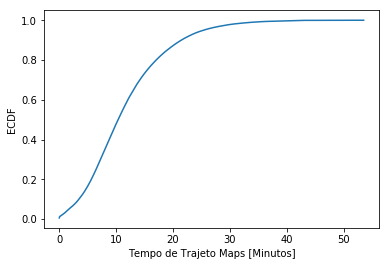

In [11]:
# CDF Maps duration
# Retirando valores entre 0 e 1 do maps

maps = pd.DataFrame()
# maps['duration'] = Occupied_Diff[Occupied_Diff['maps_duration'] >= 0]['maps_duration']
maps['duration'] = Occupied_Diff['maps_duration']

x_maps, y_maps = cdf(maps[maps['duration'] > 0].sort_values(by=['duration']))

fig, ax = plt.subplots()

ax.set_ylabel('ECDF')
ax.set_xlabel('Tempo de Trajeto Maps [Minutos]')

plt.plot(x_maps, y_maps)

# plt.savefig('CDF_Maps.pdf', bbox_inches='tight')

/home/victor/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3129: UserWarning: Attempted to set non-positive xlimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive xlimits for log-scale axis; '


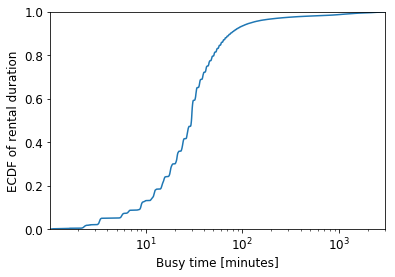

In [38]:
# CDF Ocupação de carros normais
x, y = cdf(Occupied_Diff.sort_values(by=['duration']))
plt.plot(x,y)

plt.ylabel('ECDF of rental duration')
plt.xlabel('Busy time [minutes]')

plt.xscale('log')

plt.xlim(0,max(x))
plt.ylim(0,1)

plt.savefig('../plots/busyCDF.pdf')
plt.show()

/home/victor/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3129: UserWarning: Attempted to set non-positive xlimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive xlimits for log-scale axis; '


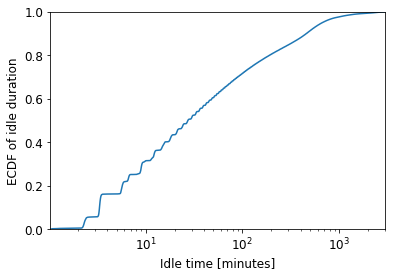

In [37]:
# CDF Viagens de carros normais

x, y = cdf(Parked_Diff.sort_values(by='duration'))
plt.plot(x,y)

plt.ylabel('ECDF of idle duration')
plt.xlabel('Idle time [minutes]')

plt.xscale('log')

plt.xlim(0,max(x))
plt.ylim(0,1)

plt.savefig('../plots/idleCDF.pdf')
plt.show()

In [ ]:
# Lendo dados após fitting

ocioso_pareto = pd.read_csv('ocioso_pareto.csv', usecols=[1,2])
ocioso_weibull = pd.read_csv('ocioso_weibull.csv', usecols=[1,2])
ocupado_pareto = pd.read_csv('ocupado_pareto.csv', usecols=[1,2])
ocupado_weibull = pd.read_csv('ocupado_weibull.csv', usecols=[1,2])

/home/victor/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3129: UserWarning: Attempted to set non-positive xlimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive xlimits for log-scale axis; '


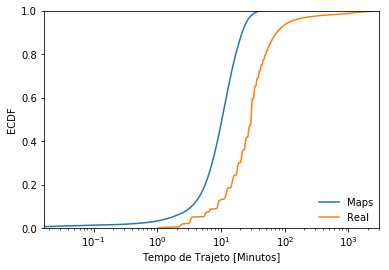

In [14]:
# Comparação maps e tempo real em minutos e escala logaritma

x, y = cdf(Occupied_Diff.sort_values(by=['duration']))

# plt.title('Comparação Duração Real x Duração Google Maps')

plt.xscale('log')

# horizontal = [0.5 for i in range(len(x))]
# plt.plot(range(len(x)), horizontal, '--')

# vertical = []
# plt.plot()

plt.ylabel('ECDF')
plt.xlabel('Tempo de Trajeto [Minutos]')

plt.plot(x_maps, y_maps, label='Maps')
plt.plot(x,y, label='Real')

plt.xlim(0,max(x))
plt.ylim(0,1)

plt.legend(loc=4, borderaxespad=0.2, frameon=False)

plt.show()
# plt.savefig('maps_real_comparacao.pdf', bbox_inches='tight')

### Retirando as viagens que iniciaram e terminaram as viagens no mesmo local

In [16]:
# Adicionando valor de distancia no dataframe
distance = []
for i in range(len(dfOccupied)):
    distance.append(haversine(dfOccupied['Start_lon'].iloc[i],dfOccupied['Start_lat'].iloc[i],
                              dfOccupied['End_lon'].iloc[i],dfOccupied['End_lat'].iloc[i]))
dfOccupied['distance'] = distance

In [17]:
dfOccupied.tail()

,Start_time,End_time,Id,Start_lat,Start_lon,End_lat,End_lon,Maps_duration,Real_duration,Fuel_start,Fuel_end,distance
1232256,2018-07-16 23:33:29.434806,2018-07-16 23:56:55.642463,JTDKDTB34G1589080,49.283900,-123.107666,49.234790,-123.168877,20.166667,33.105323,33,29,7034.908913
1232257,2018-07-16 23:42:03.421044,2018-07-16 23:56:55.642463,JTDKDTB33E1079414,49.278633,-123.111267,49.231330,-122.890213,25.566667,23.436794,68,69,16872.895683
1232258,2018-07-16 23:48:25.695536,2018-07-16 23:56:55.642463,JTDKDTB38H1598298,49.204853,-122.907715,49.225350,-122.915688,7.216667,14.870357,46,40,2350.099221
1232259,2018-07-16 23:48:25.695536,2018-07-16 23:56:55.642463,JTDKDTB35G1589170,49.270752,-123.149033,49.253910,-123.128868,7.833333,8.499115,83,81,2375.137429
1232260,2018-07-16 22:44:55.536166,2018-07-16 23:56:55.642463,JTDKDTB38G1126486,49.269108,-123.157928,49.270626,-123.249428,12.150000,8.499115,38,38,6636.700414


In [18]:
dfGreatDistance = dfOccupied[(dfOccupied['distance'] > 150) & (dfOccupied['Real_duration'] < 3000)]

In [19]:
dfGreatDistance.describe()

,Start_lat,Start_lon,End_lat,End_lon,Maps_duration,Real_duration,Fuel_start,Fuel_end,distance
count,857665.000000,857665.000000,857665.000000,857665.000000,857665.000000,857665.000000,857665.000000,857665.000000,857665.000000
mean,49.264814,-123.106344,49.264806,-123.106378,12.043014,78.718924,56.775408,56.771567,4038.456763
std,0.023993,0.060168,0.024004,0.060232,7.045019,256.061423,21.734860,21.754699,3277.408672
min,49.190746,-123.259369,49.190746,-123.259369,0.166667,1.044289,9.000000,9.000000,150.003114
25%,49.254513,-123.135872,49.254486,-123.135872,6.933333,18.927987,38.000000,38.000000,1781.417564
50%,49.266180,-123.111427,49.266170,-123.111488,10.683333,30.779362,58.000000,58.000000,3168.361026
75%,49.279840,-123.078926,49.279846,-123.078964,15.750000,50.471893,77.000000,77.000000,5312.543682
max,49.373573,-122.882744,49.374638,-122.882118,53.483333,2999.869118,85.000000,85.000000,27470.097214


In [20]:
# Foi retirado todas as viagens que sairam e chegaram no mesmo local ou proximo
dfGreatDistance[(dfGreatDistance['End_lat']==dfGreatDistance['Start_lat']) & 
                (dfGreatDistance['End_lon']==dfGreatDistance['Start_lon'])]

,Start_time,End_time,Id,Start_lat,Start_lon,End_lat,End_lon,Maps_duration,Real_duration,Fuel_start,Fuel_end,distance


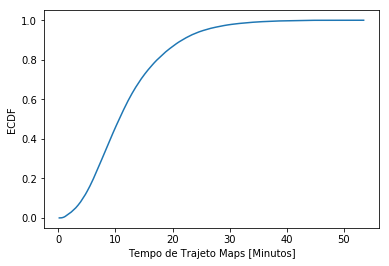

In [21]:
# CDF Maps duration
# Retirando valores entre 0 e 1 do maps

maps = pd.DataFrame()
# maps['duration'] = Occupied_Diff[Occupied_Diff['maps_duration'] >= 0]['maps_duration']
maps['duration'] = dfGreatDistance['Maps_duration']

x_maps, y_maps = cdf(maps[maps['duration'] > 0].sort_values(by=['duration']))

fig, ax = plt.subplots()

ax.set_ylabel('ECDF')
ax.set_xlabel('Tempo de Trajeto Maps [Minutos]')

plt.plot(x_maps, y_maps)

# plt.savefig('CDF_Maps.pdf', bbox_inches='tight')

/home/victor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/victor/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3129: UserWarning: Attempted to set non-positive xlimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive xlimits for log-scale axis; '


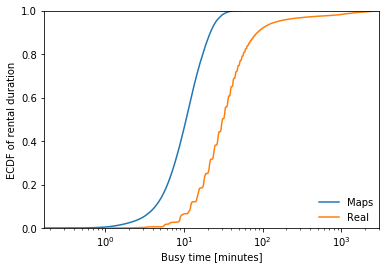

In [22]:
# Comparação maps e tempo real em minutos e escala logaritma
dfGreatDistance['duration'] = dfGreatDistance['Real_duration']
x, y = cdf(dfGreatDistance.sort_values(by=['duration']))

# plt.title('Comparação Duração Real x Duração Google Maps')

plt.xscale('log')

plt.ylabel('ECDF of rental duration')
plt.xlabel('Busy time [minutes]')

plt.plot(x_maps, y_maps, label='Maps')
plt.plot(x,y, label='Real')

plt.xlim(0,max(x))
plt.ylim(0,1)

plt.legend(loc=4, borderaxespad=0.2, frameon=False)

# plt.show()
plt.savefig('../plots/maps_real_comparacao.pdf', bbox_inches='tight')

## Tarde e noite para dias de semana

In [23]:
tarde = []
noite = []

for i in range(len(Occupied_Diff)):
    start = Occupied_Diff['Start_time'].iloc[i]
    hora = start.hour
    dia = int(start.strftime('%w'))
    
    if ((hora >= 7 and hora <= 10) and (dia > 0  and dia < 6)):
        tarde.append([Occupied_Diff['Id'].iloc[i], Occupied_Diff['Start_time'].iloc[i], 
                      Occupied_Diff['duration'].iloc[i]])
    elif ((hora >= 16 and hora <= 20) and (dia > 0  and dia < 6)):
        noite.append([Occupied_Diff['Id'].iloc[i], Occupied_Diff['Start_time'].iloc[i], 
                      Occupied_Diff['duration'].iloc[i]])

tarde = pd.DataFrame(tarde, columns=['car_id', 'start', 'duration'])
noite = pd.DataFrame(noite, columns=['car_id', 'start', 'duration'])
todos = Occupied_Diff

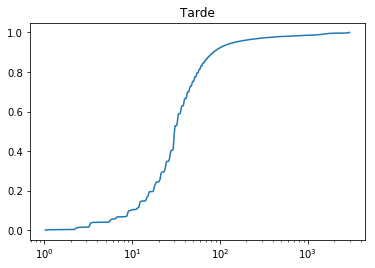

In [24]:
x, y = cdf(tarde.sort_values(by='duration'))
plt.xscale('log')
plt.title('Tarde')
plt.plot(x,y)

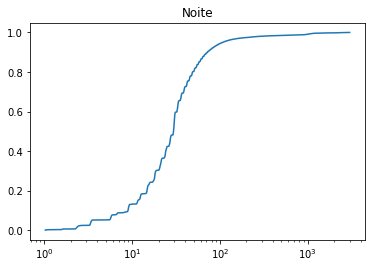

In [25]:
x, y = cdf(noite.sort_values(by='duration'))
plt.xscale('log')
plt.title('Noite')
plt.plot(x,y)

In [26]:
# Durações menores ou iguais que 28 horas
# Em analise
tarde = tarde[tarde['duration'] <= 28*60]
noite = noite[noite['duration'] <= 28*60]
todos = Occupied_Diff[Occupied_Diff['duration'] <= 28*60]

/home/victor/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3129: UserWarning: Attempted to set non-positive xlimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive xlimits for log-scale axis; '


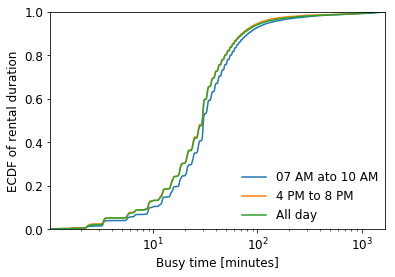

In [27]:
matplotlib.rc('font', size=12)

fig, ax = plt.subplots()

x, y = cdf(tarde.sort_values(by='duration'))
ax.plot(x,y, label='7 AM to 10 AM')# marker='o', markevery=[30,140,280,400,580,800,960,1010,1100])

x, y = cdf(noite.sort_values(by='duration'))
ax.plot(x,y, label='4 PM to 8 PM') #marker='s', markevery=[30,60,120,190,280,340,392,400,406])

x, y = cdf(todos.sort_values(by='duration'))
ax.plot(x,y, label='All day') #marker='^', markevery=[20,120,350,600,960,1400,2200,2800,3600,4300,4550])

# Modificando os labels dos minutos
ax.xaxis.set_ticks(np.arange(0, 1800, 180))


fig.canvas.draw()

# labels = [item.get_text() for item in ax.get_xticklabels()]
# labels = range(0,30,3)

# ax.set_xticklabels(labels)

ax.legend(loc=4, borderaxespad=0.2, frameon=False)
ax.set_ylabel('ECDF of rental duration')
ax.set_xlabel('Busy time [minutes]')

# plt.title('load peaks hours')
plt.xscale('log')

plt.xlim(0,max(x))
plt.ylim(0,1)

# plt.show()
plt.savefig('../plots/tarde_noiteCDF_log.pdf')